# Part 1:

## For the period 1st April 19 to 30th Sept 19, Energia need to buy 100MW in each half hour of every day, based on the available data what would have been the best strategy that Energia could have used? What factors drive the decision?

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load datasets from the Excel file
data_wind = pd.read_excel("/Users/faitusjelinejoseph/Documents/Project/project2/QUBData-Part1.xlsx", sheet_name="Wind")
data_demand = pd.read_excel("/Users/faitusjelinejoseph/Documents/Project/project2/QUBData-Part1.xlsx", sheet_name="Demand")
data_prices = pd.read_excel("/Users/faitusjelinejoseph/Documents/Project/project2/QUBData-Part1.xlsx", sheet_name="Actual Prices")

# Parse date and time into a single column for easier handling
data_wind['DateTime'] = pd.to_datetime(data_wind['Start Date'] + ' ' + data_wind['Start Time 30 Minute Period'])
data_demand['DateTime'] = pd.to_datetime(data_demand['Start Date'] + ' ' + data_demand['Start Time 30 Minute Period'])
data_prices['DateTime'] = pd.to_datetime(data_prices['Start Date'] + ' ' + data_prices['Time'])

# Merge datasets based on DateTime
merged_data = pd.merge(data_wind, data_demand, on="DateTime")
merged_data = pd.merge(merged_data, data_prices, on="DateTime")


## Data Loading:
### Successfully reads in three different datasets: Wind data, Demand data, and Prices.

## Timestamp Creation: 
### Combines the Start Date and Start Time 30 Minute Period columns into a unified DateTime column for easier handling and alignment of data.

## Data Merging: 
### Combines all three datasets into a single merged_data dataframe based on the DateTime field, ensuring everything aligns chronologically.

In [21]:
merged_data.head()

,Start Date_x,Start Time 30 Minute Period_x,Actual Wind (MW),DAM Forecast ISEMWIND,IDA1 Forecast ISEMWIND,IDA2 Forecast ISEMWIND,IDA3 Forecast ISEMWIND,DateTime,Start Date_y,Start Time 30 Minute Period_y,...,IDA1 Forecast ISEMDEMAND,IDA2 Forecast ISEMDEMAND,IDA3 Forecast ISEMDEMAND,Start Date,Time,DA Price,IDA1 Price,IDA2 Price,IDA3 Price,BM Price
0,31/03/2019,23:00:00,549,404,412,NaN,NaN,2019-03-31 23:00:00,31/03/2019,23:00:00,...,3712,NaN,NaN,31/03/2019,23:00:00,49.47,53.600,NaN,NaN,26.44
1,31/03/2019,23:30:00,558,404,412,NaN,NaN,2019-03-31 23:30:00,31/03/2019,23:30:00,...,3712,NaN,NaN,31/03/2019,23:30:00,49.47,47.878,NaN,NaN,39.25
2,01/04/2019,00:00:00,544,380,401,NaN,NaN,2019-01-04 00:00:00,01/04/2019,00:00:00,...,3456,NaN,NaN,01/04/2019,00:00:00,35.00,44.000,NaN,NaN,18.65
3,01/04/2019,00:30:00,492,380,401,NaN,NaN,2019-01-04 00:30:00,01/04/2019,00:30:00,...,3456,NaN,NaN,01/04/2019,00:30:00,35.00,43.000,NaN,NaN,27.91
4,01/04/2019,01:00:00,459,366,391,NaN,NaN,2019-01-04 01:00:00,01/04/2019,01:00:00,...,3234,NaN,NaN,01/04/2019,01:00:00,35.00,43.000,NaN,NaN,28.39


## Data Cleaning:

###  The goal is to limit the dataset to the specific period from April 1, 2019, to September 30, 2019. This aligns with the requirements for Part 1 of the project where the analysis is restricted to this timeframe.

In [22]:
# Filter for the period 1st April 2019 to 30th September 2019
start_date = "2019-04-01"
end_date = "2019-09-30"
merged_data = merged_data[(merged_data['DateTime'] >= start_date) & (merged_data['DateTime'] <= end_date)]

# Handle irrelevant timeframes for IDA2 and IDA3 forecasts
relevant_timeframe_ida2 = (merged_data['DateTime'].dt.hour >= 11)  # IDA2: 11:00 to 23:00
merged_data.loc[~relevant_timeframe_ida2, ['IDA2 Forecast ISEMWIND', 'IDA2 Forecast ISEMDEMAND']] = np.nan

relevant_timeframe_ida3 = (merged_data['DateTime'].dt.hour >= 17)  # IDA3: 17:00 to 23:00
merged_data.loc[~relevant_timeframe_ida3, ['IDA3 Forecast ISEMWIND', 'IDA3 Forecast ISEMDEMAND']] = np.nan

# Interpolate missing values for IDA2 and IDA3
merged_data['IDA2 Forecast ISEMWIND'] = merged_data['IDA2 Forecast ISEMWIND'].interpolate()
merged_data['IDA3 Forecast ISEMWIND'] = merged_data['IDA3 Forecast ISEMWIND'].interpolate()

### The IDA2 market operates between 11:00 and 23:00 daily. Forecast data outside this timeframe is irrelevant, so it is set to NaN.

### The IDA3 market operates between 17:00 and 23:00. Similarly, forecast data outside this timeframe is irrelevant and set to NaN.

## Feature Engineering: 

### Adding these features helps enrich the dataset with meaningful variables that capture trends, relationships, and patterns relevant to predicting electricity prices or demand. Here’s the significance of each feature:

In [23]:
# Feature Engineering: Calculate additional features
merged_data['Net Demand'] = merged_data['Actual Demand (MW)'] - merged_data['Actual Wind (MW)']  # Net Demand
merged_data['Wind Demand Ratio'] = merged_data['Actual Wind (MW)'] / merged_data['Actual Demand (MW)']  # Ratio of wind to demand
merged_data['Price Spread'] = merged_data['DA Price'] - merged_data['BM Price']  # Spread between DA and BM prices
merged_data['Hourly Trend'] = merged_data['DateTime'].dt.hour  # Hourly trend for periodicity
merged_data['Day of Week'] = merged_data['DateTime'].dt.weekday  # Day of the week (Monday=0, Sunday=6)

### Calculates the demand that must be fulfilled by non-renewable energy sources (like gas or coal) after accounting for wind generation.

### Computes the proportion of total demand met by wind energy.

### The difference between Day-Ahead Market (DA) and Balancing Market (BM) prices for electricity.

### Extracts the hour from the DateTime field to identify periodic demand and price fluctuations throughout the day

### Extracts the day of the week (0 = Monday, 6 = Sunday) to analyze weekday vs. weekend patterns.

In [24]:
# Ensure Energia buys exactly 100MW in each half-hour period
merged_data['Electricity Purchased'] = 100  # Set a constant purchase of 100MW for every interval
merged_data['Remaining Demand'] = merged_data['Actual Demand (MW)'] - merged_data['Electricity Purchased']

### Ensures that Energia consistently buys exactly 100MW of electricity in every half-hour period.

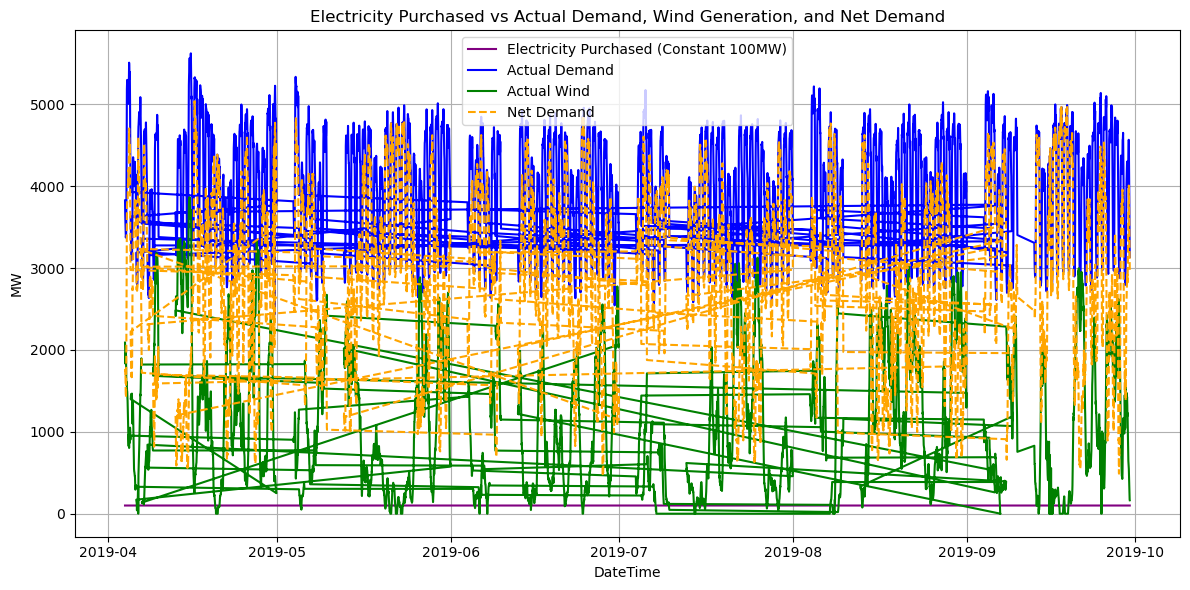

In [25]:
# Visualize Demand, Wind, Net Demand, and Purchased Electricity
plt.figure(figsize=(12, 6))
plt.plot(merged_data['DateTime'], merged_data['Electricity Purchased'], label='Electricity Purchased (Constant 100MW)', color='purple')
plt.plot(merged_data['DateTime'], merged_data['Actual Demand (MW)'], label='Actual Demand', color='blue')
plt.plot(merged_data['DateTime'], merged_data['Actual Wind (MW)'], label='Actual Wind', color='green')
plt.plot(merged_data['DateTime'], merged_data['Net Demand'], label='Net Demand', color='orange', linestyle='--')
plt.xlabel('DateTime')
plt.ylabel('MW')
plt.title('Electricity Purchased vs Actual Demand, Wind Generation, and Net Demand')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### The constant purchase of 100MW highlights the critical need for precise forecasting. Electricity cannot be stored between trading periods, so Energia must buy exactly what is needed for each half-hour period.

## Machine Language Training 

In [26]:
# Define features (forecasts and engineered features) and target (actual wind generation)
features = ['DAM Forecast ISEMWIND', 'IDA1 Forecast ISEMWIND', 'IDA2 Forecast ISEMWIND', 'IDA3 Forecast ISEMWIND', 
            'Net Demand', 'Wind Demand Ratio', 'Price Spread', 'Hourly Trend', 'Day of Week']
X = merged_data[features].fillna(0)  # Replace any remaining NaN with 0
y = merged_data['Actual Wind (MW)']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print(rf_model.score(X_test, y_test))

# Make predictions and evaluate the model
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (Random Forest) for Specified Period: {mae}")

0.9960365414366986
Mean Absolute Error (Random Forest) for Specified Period: 29.386291012838804


### Trains a Random Forest regression model, and evaluates its performance to predict wind generation (Actual Wind (MW)).

### Training Set (80%): Used to train the Random Forest model.

### Testing Set (20%): Used to evaluate the model's performance on unseen data.

## The prediction is 99.6% acurate
## MAE quantifies the prediction error, highlighting areas for improvement.

## The difference between the predicted values and the actual wind generation values is 29 MW.

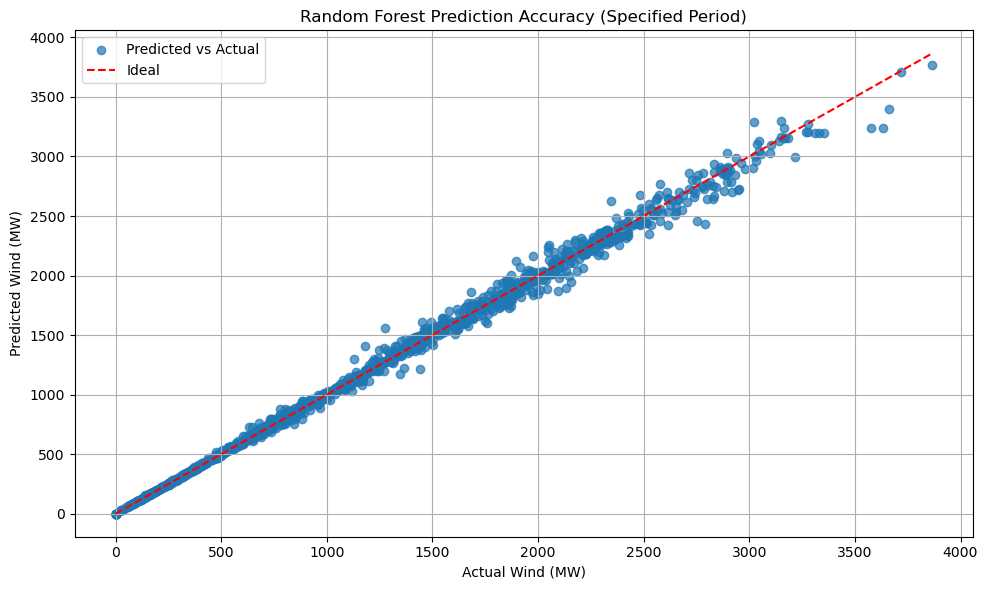

In [27]:
# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal')
plt.xlabel('Actual Wind (MW)')
plt.ylabel('Predicted Wind (MW)')
plt.title('Random Forest Prediction Accuracy (Specified Period)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Alignment with the Ideal Line: 

### Points close to the red dashed line indicate that the model's predictions were accurate and matched the actual values. This suggests that the model is successfully capturing the patterns in wind generation.

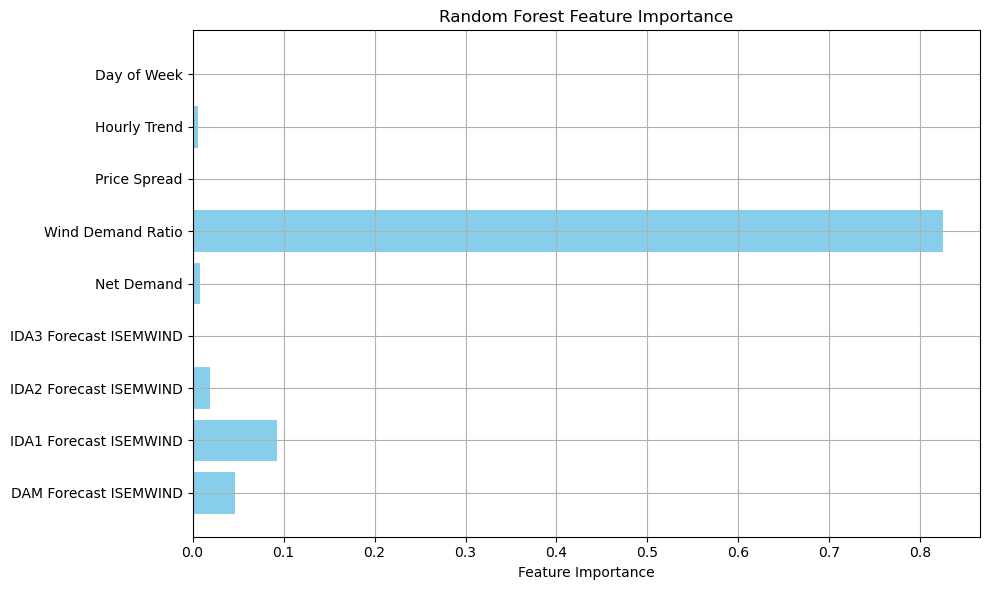

DAM Forecast ISEMWIND: 0.0464
IDA1 Forecast ISEMWIND: 0.0925
IDA2 Forecast ISEMWIND: 0.0189
IDA3 Forecast ISEMWIND: 0.0016
Net Demand: 0.0079
Wind Demand Ratio: 0.8244
Price Spread: 0.0015
Hourly Trend: 0.0057
Day of Week: 0.0011


In [28]:
# Feature importance analysis
feature_importance = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.grid()
plt.tight_layout()
plt.show()

# Print feature importance
for feature, importance in zip(features, feature_importance):
    print(f"{feature}: {importance:.4f}")


## Visualizes the importance of each feature in the Random Forest regression model. 

##  The proportion of wind energy contributing to total demand is a critical determinant of wind generation and electricity purchasing strategies.

### Forecasts for wind generation across the various markets (DAM, IDA1-3) also carry significant importance.

### Among these, IDA1 and IDA2 forecasts stand out, emphasizing the utility of early intra-day auction forecasts in refining purchasing strategies.

# Conclusion:
# DAM typically offers the most stable and predictable prices, making it the primary market for securing the bulk of the required 100MW (e.g., 70–80MW). This minimizes costs and risks associated with forecast errors.

# Leverage DAM demand and wind forecasts to allocate purchases effectively.